# Tree
Questo notebook serve per racchiudere quanto di utile per lo sviluppo di codice per valutare la scelta di alberi decisionali per il dataset scelto.

## Scaricamento dei dati

In [1]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip"]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_train.csv', 'dataset/y_train.csv']


## Estrazione dei dati

In [2]:
import pandas as pd

def load_data(x_path, y_path):
  """
  Loads X.csv and the second column of y.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X.csv file.
    y_path (str): The path to the y.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X.csv
                      and the second column of y.csv.
  """
  x = pd.read_csv(x_path)
  y = pd.read_csv(y_path)

  # Assuming y has at least 2 columns and the second column is at index 1
  if y.shape[1] > 1:
    combined_data = x.copy()
    combined_data['y_target'] = y.iloc[:, 1]
    return combined_data
  else:
    print("Error: y.csv does not have a second column.")
    return x

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_path = 'dataset/X_train.csv'
y_path = 'dataset/y_train.csv'

data = load_data(x_path, y_path)

# You can now work with the 'data' DataFrame
print(data.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Creazione training-set testing-set

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (594100, 9)
Dimensione data_test: (148525, 9)


## Cambio nome delle feature

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted


# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None):
        self._is_fitted = True  # Mark as fitted
        return self

    def _rename_df(self, df):
        df = df.drop(columns='id', errors='ignore')
        if df.shape[1] != len(self.column_names):
            raise ValueError(f"Expected {len(self.column_names)} columns, got {df.shape[1]}")
        df.columns = self.column_names
        return df

    def transform(self, X):
        check_is_fitted(self, '_is_fitted')  # Check if fit was called
        return self._rename_df(X)

# ---------------------- Example Usage ----------------------

# Example column names
feature_names = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed'
]

X_train = data_train.iloc[:, :-1]  # tutte le colonne tranne l'ultima → feature
y_train = data_train.iloc[:, -1]   # solo l'ultima colonna → target


pipeline = Pipeline([
    ('rename', FeatureRenamer(column_names=feature_names)),
])

pipeline.fit(X_train, y_train)

X_transformed = pipeline.transform(X_train)

print("Transformed DataFrame:")
print(X_transformed.head())

Transformed DataFrame:
        torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067      74.8000            19.500       646.1000    1005.8400   
601458      67.0332            20.152       602.4063     958.4962   
77053       67.8000             8.000       546.7000      24.3840   
664037      53.9000             5.500       532.1000     360.8832   
346977      73.3000            17.750       636.3000    1025.9570   

        indicated_air_speed  net_power  compressor_speed  
331067             56.00000  100.19000          96.47000  
601458             96.97656   99.65235          94.02332  
77053              73.68750  100.22000          91.61000  
664037             61.87500   88.91000          99.78000  
346977             89.50000   99.98000          95.95000  


/home/tizianoc/.local/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Standardizzazione

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted


# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None):
        self._is_fitted = True  # Mark as fitted
        return self

    def _rename_df(self, df):
        df = df.drop(columns='id', errors='ignore')
        if df.shape[1] != len(self.column_names):
            raise ValueError(f"Expected {len(self.column_names)} columns, got {df.shape[1]}")
        df.columns = self.column_names
        return df

    def transform(self, X):
        check_is_fitted(self, '_is_fitted')  # Check if fit was called
        return self._rename_df(X)

class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.columns_ = X.columns  # trailing underscore indicates fitted attribute
        self.scaler.fit(X)
        return self

    def transform(self, X):
        check_is_fitted(self.scaler, 'mean_')  # standard attribute for StandardScaler
        X_scaled = pd.DataFrame(self.scaler.transform(X), columns=self.columns_, index=X.index)
        return X_scaled

# ---------------------- Example Usage ----------------------

# Example column names
feature_names = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed'
]

X_train = data_train.iloc[:, :-1]  # tutte le colonne tranne l'ultima → feature
y_train = data_train.iloc[:, -1]   # solo l'ultima colonna → target


pipeline = Pipeline([
    ('rename', FeatureRenamer(column_names=feature_names)),
    ('scale', DataScaler()),
])

pipeline.fit(X_train, y_train)

X_transformed = pipeline.transform(X_train)

## Decision tree prima esecuzione

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted


# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None):
        self._is_fitted = True  # Mark as fitted
        return self

    def _rename_df(self, df):
        df = df.drop(columns='id', errors='ignore')
        if df.shape[1] != len(self.column_names):
            raise ValueError(f"Expected {len(self.column_names)} columns, got {df.shape[1]}")
        df.columns = self.column_names
        return df

    def transform(self, X):
        check_is_fitted(self, '_is_fitted')  # Check if fit was called
        return self._rename_df(X)

class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.columns_ = X.columns  # trailing underscore indicates fitted attribute
        self.scaler.fit(X)
        return self

    def transform(self, X):
        check_is_fitted(self.scaler, 'mean_')  # standard attribute for StandardScaler
        X_scaled = pd.DataFrame(self.scaler.transform(X), columns=self.columns_, index=X.index)
        return X_scaled

class DecisionTreeTrainer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = DecisionTreeClassifier(random_state=42)

    def fit(self, X, y):
        self.model.fit(X, y)
        self.is_fitted_ = True   # <-- indicatore di fit
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')  # controlla se fit è stato fatto
        return self.model.predict(X)

# ---------------------- Esecuzione Pipeline ----------------------

feature_names = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed'
]

X_train = data_train.iloc[:, :-1]  # tutte le colonne tranne l'ultima → feature
y_train = data_train.iloc[:, -1]   # solo l'ultima colonna → target


pipeline = Pipeline([
    ('rename', FeatureRenamer(column_names=feature_names)),
    ('scale', DataScaler()),
    ('model', DecisionTreeTrainer())
])

pipeline.fit_transform(X_train, y_train)

# Trasformiamo i dati per poterli passare alla funzione di predizione
X_transformed = pipeline.transform(X_train)

# Eseguiamo le predizioni
y_pred = pipeline.named_steps['model'].predict(X_transformed)

check_is_fitted(pipeline.named_steps['model'])

print("✔️ Pipeline fitted correttamente.")
print("Predizioni:", y_pred)
print("Feature names:", pipeline.named_steps['rename'].column_names)
print("Predizioni, numero di elementi:", len(y_pred))



✔️ Pipeline fitted correttamente.
Predizioni: [1 0 0 ... 1 1 0]
Feature names: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']
Predizioni, numero di elementi: 594100


### Pipeline tree

In [ ]:
pipeline

Pipeline(steps=[('rename',
                 FeatureRenamer(column_names=['torque_meas', 'outside_air_temp',
                                              'mean_gas_temp', 'power_avail',
                                              'indicated_air_speed',
                                              'net_power',
                                              'compressor_speed'])),
                ('scale', DataScaler()), ('model', DecisionTreeTrainer())])

## K-fold

In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import cross_val_score, KFold


# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None):
        self._is_fitted = True  # Mark as fitted
        return self

    def _rename_df(self, df):
        df = df.drop(columns='id', errors='ignore')
        if df.shape[1] != len(self.column_names):
            raise ValueError(f"Expected {len(self.column_names)} columns, got {df.shape[1]}")
        df.columns = self.column_names
        return df

    def transform(self, X):
        check_is_fitted(self, '_is_fitted')  # Check if fit was called
        return self._rename_df(X)

class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.columns_ = X.columns  # trailing underscore indicates fitted attribute
        self.scaler.fit(X)
        return self

    def transform(self, X):
        check_is_fitted(self.scaler, 'mean_')  # standard attribute for StandardScaler
        X_scaled = pd.DataFrame(self.scaler.transform(X), columns=self.columns_, index=X.index)
        return X_scaled

class DecisionTreeTrainer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = DecisionTreeClassifier(random_state=42)

    def fit(self, X, y):
        self.model.fit(X, y)
        self.is_fitted_ = True   # <-- indicatore di fit
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')  # controlla se fit è stato fatto
        return self.model.predict(X)

    def predict_proba(self, X):
        check_is_fitted(self, 'is_fitted_')
        return self.model.predict_proba(X)


class DecisionTreeCrossValidator(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits=5, random_state=None, shuffle=True):
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        self.cv_scores = None
        self.model = DecisionTreeClassifier(criterion="gini", random_state=42)

    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)

        print(f"\nPerforming {self.n_splits}-Fold Cross-Validation on training data...")
        self.cv_scores = cross_val_score(
            self.model,
            X,
            y,
            cv=kf,
            scoring='precision'  # puoi cambiare scoring se vuoi
        )
        print("Cross-validation complete.")
        print(f"Cross-validation scores ({self.n_splits} folds): {self.cv_scores}")
        print(f"Mean CV score: {self.cv_scores.mean():.4f}")
        print(f"Standard deviation of CV scores: {self.cv_scores.std():.4f}")

        return self


    def transform(self, X):
        if self.cv_scores is None:
            raise RuntimeError("Cross-validation has not been performed yet. Call fit() first.")
        # Non modifichiamo X, solo ritorniamo lo stesso DataFrame per compatibilità pipeline
        return X

    def get_cv_scores(self):
        if self.cv_scores is None:
            raise RuntimeError("Cross-validation has not been performed yet. Call fit() first.")
        return self.cv_scores


# ---------------------- Example Usage ----------------------

# Example column names
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed'
]

X_train = data_train.iloc[:, :-1]  # tutte le colonne tranne l'ultima → feature
y_train = data_train.iloc[:, -1]   # solo l'ultima colonna → target

# Pipeline
# Cross-validation pipeline (solo valutazione)
pipeline_cv = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('cross_validate_decision_tree', DecisionTreeCrossValidator(n_splits=5, random_state=42))
])

# Addestramento e predizione finale
pipeline_final = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('train_decision_tree', DecisionTreeTrainer())
])

# Esegui la validazione incrociata
pipeline_cv.fit(X_train, y_train)

# Fit finale per predizione
pipeline_final.fit(X_train, y_train)

# Predizione
y_pred = pipeline_final.named_steps['train_decision_tree'].predict(
    pipeline_final.named_steps['scale_data'].transform(
        pipeline_final.named_steps['rename_features'].transform(X_train)
    )
)

# Verifiche
check_is_fitted(pipeline_final.named_steps['train_decision_tree'])
print("✔️ Pipeline fitted correttamente.")
print("Predizioni:", y_pred)
print("Numero predizioni:", len(y_pred))
print("Feature names:", pipeline_final.named_steps['rename_features'].column_names)


Performing 5-Fold Cross-Validation on training data...
Cross-validation complete.
Cross-validation scores (5 folds): [0.99586397 0.99588101 0.99645925 0.99556749 0.9958109 ]
Mean CV score: 0.9959
Standard deviation of CV scores: 0.0003
✔️ Pipeline fitted correttamente.
Predizioni: [1 0 0 ... 1 1 0]
Numero predizioni: 594100
Feature names: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']


In [ ]:
pipeline_cv

Pipeline(steps=[('rename_features',
                 FeatureRenamer(column_names=['torque_meas', 'outside_air_temp',
                                              'mean_gas_temp', 'power_avail',
                                              'indicated_air_speed',
                                              'net_power',
                                              'compressor_speed'])),
                ('scale_data', DataScaler()),
                ('cross_validate_decision_tree',
                 DecisionTreeCrossValidator(random_state=42))])

In [ ]:
pipeline_final

Pipeline(steps=[('rename_features',
                 FeatureRenamer(column_names=['torque_meas', 'outside_air_temp',
                                              'mean_gas_temp', 'power_avail',
                                              'indicated_air_speed',
                                              'net_power',
                                              'compressor_speed'])),
                ('scale_data', DataScaler()),
                ('train_decision_tree', DecisionTreeTrainer())])

### Tree visualization

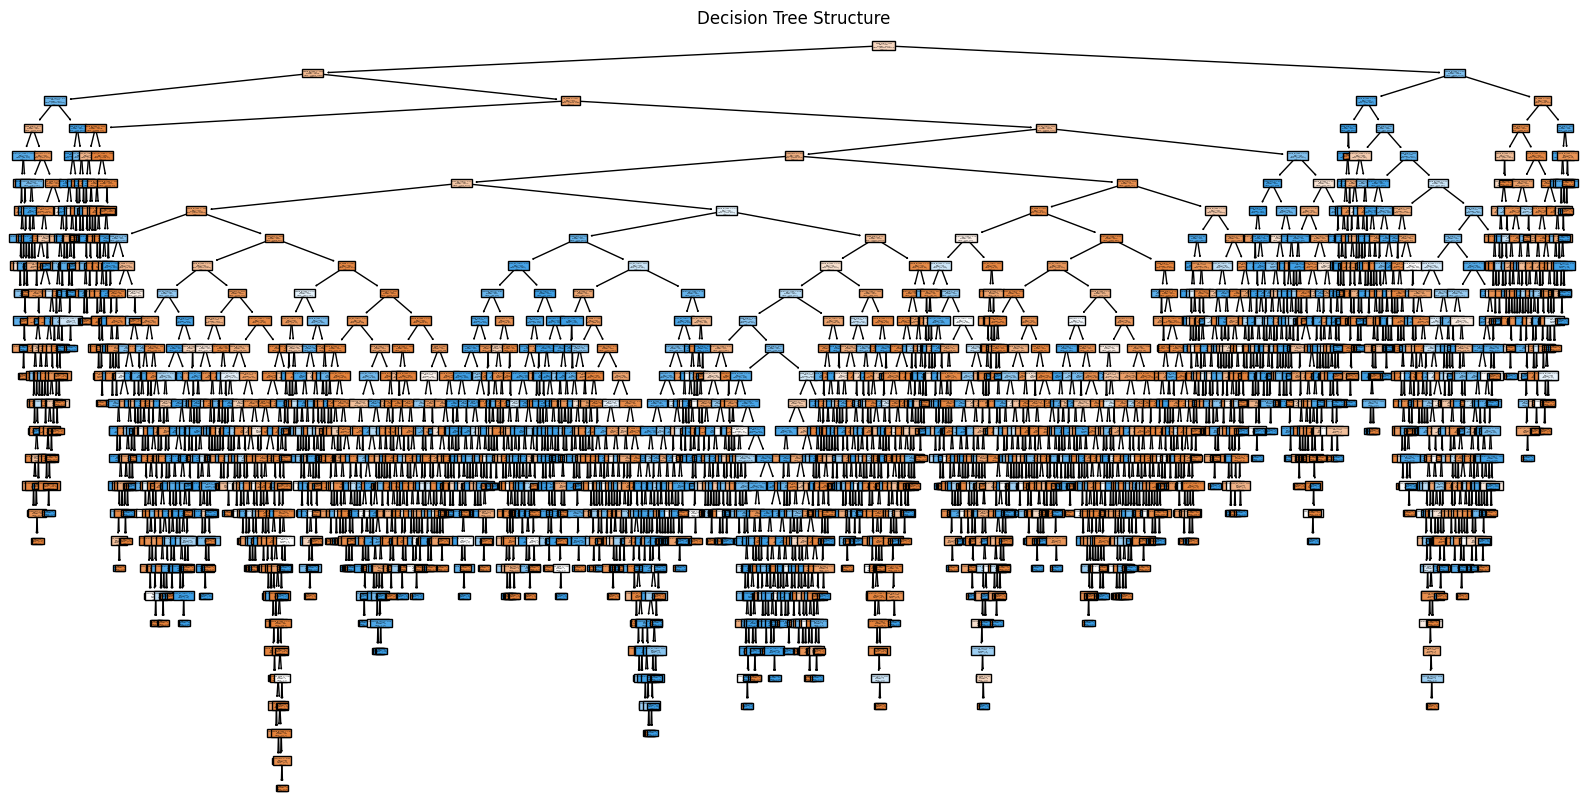

In [ ]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

# Estrai il modello addestrato dalla pipeline
decision_tree_model = pipeline.named_steps['model'].model

# Visualizza l'albero decisionale
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, feature_names=feature_names, class_names=['0', '1'], filled=True)
plt.title("Decision Tree Structure")
plt.show()

### Performance


Performance Evaluation Results:
Accuracy: 1.0000
Precision: 1.0000
Sensitivity (Recall): 1.0000
Specificity: 1.0000

Confusion Matrix:
[[354560      0]
 [     0 239540]]


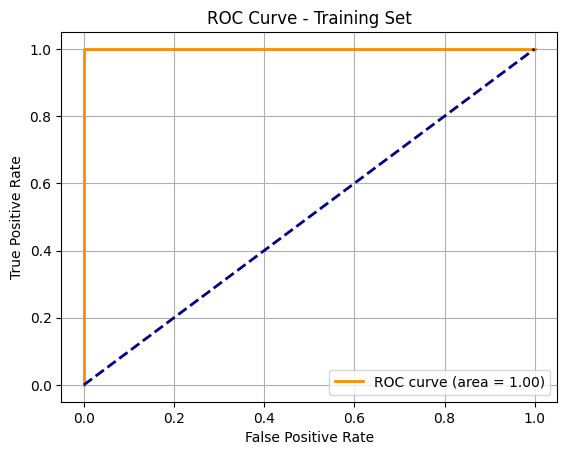

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

class DecisionTreePerformanceEvaluator:
    def __init__(self, model, X, y, n_splits=5):
        """
        Classe per valutare le performance di un modello Decision Tree con validazione a 5-fold.

        Args:
            model: Modello Decision Tree addestrato.
            X: Feature del dataset.
            y: Target del dataset.
            n_splits: Numero di fold per la validazione incrociata.
        """
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.results = {}

    def evaluate(self):
        """
        Valuta le performance del modello e calcola le metriche.
        """
        # Predizioni
        y_pred = self.model.predict(self.X)

        # Calcolo delle metriche
        self.results['accuracy'] = accuracy_score(self.y, y_pred)
        self.results['precision'] = precision_score(self.y, y_pred, zero_division=0)
        self.results['sensitivity'] = recall_score(self.y, y_pred, zero_division=0)

        # Confusion matrix e specificità
        cm = confusion_matrix(self.y, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            self.results['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        else:
            self.results['specificity'] = None
        self.results['confusion_matrix'] = cm

        # ROC curve e AUC
        if hasattr(self.model, "predict_proba"):
            y_prob = self.model.predict_proba(self.X)[:, 1]
            fpr, tpr, _ = roc_curve(self.y, y_prob)
            self.results['fpr'] = fpr
            self.results['tpr'] = tpr
            self.results['roc_auc'] = auc(fpr, tpr)
        else:
            self.results['fpr'] = None
            self.results['tpr'] = None
            self.results['roc_auc'] = None

    def display_results(self):
        """
        Mostra i risultati delle metriche e la curva ROC (se disponibile).
        """
        print("\nPerformance Evaluation Results:")
        print(f"Accuracy: {self.results['accuracy']:.4f}")
        print(f"Precision: {self.results['precision']:.4f}")
        print(f"Sensitivity (Recall): {self.results['sensitivity']:.4f}")
        print(f"Specificity: {self.results['specificity']:.4f}")
        print("\nConfusion Matrix:")
        print(self.results["confusion_matrix"])

        if self.results["roc_auc"] is not None:
            plt.figure()
            plt.plot(self.results["fpr"], self.results["tpr"], color='darkorange', lw=2,
                     label=f'ROC curve (area = {self.results["roc_auc"]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve - Training Set')
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.show()
        else:
            print("\nROC curve and AUC not available (predict_proba not supported).")

# Esempio di utilizzo della classe DecisionTreePerformanceEvaluator
evaluator = DecisionTreePerformanceEvaluator(
    model=pipeline_final.named_steps['train_decision_tree'],
    X=pipeline_final.named_steps['scale_data'].transform(
        pipeline_final.named_steps['rename_features'].transform(X_train)
    ),
    y=y_train
)

# Esegui la valutazione
evaluator.evaluate()
evaluator.display_results()

## Aggiunta di Cost Complexity Pruning
Come atteso il primo run del decision tree ha fatto un completo overfit, la complessità dell'albero visualizzato in precedenza e i valori di indicazione di performance ne sono testimoni

In [21]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# ---------------------- Custom Transformers ----------------------

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None):
        self._is_fitted = True  # Mark as fitted
        return self

    def _rename_df(self, df):
        df = df.drop(columns='id', errors='ignore')
        if df.shape[1] != len(self.column_names):
            raise ValueError(f"Expected {len(self.column_names)} columns, got {df.shape[1]}")
        df.columns = self.column_names
        return df

    def transform(self, X):
        check_is_fitted(self, '_is_fitted')  # Check if fit was called
        return self._rename_df(X)

class DataScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.columns_ = X.columns  # trailing underscore indicates fitted attribute
        self.scaler.fit(X)
        return self

    def transform(self, X):
        check_is_fitted(self.scaler, 'mean_')  # standard attribute for StandardScaler
        X_scaled = pd.DataFrame(self.scaler.transform(X), columns=self.columns_, index=X.index)
        return X_scaled

class DecisionTreeTrainer(BaseEstimator, TransformerMixin):
    def __init__(self, ccp_alpha=0.0):  # <- aggiunto parametro
        self.ccp_alpha = ccp_alpha
        self.model = DecisionTreeClassifier(random_state=42, ccp_alpha=self.ccp_alpha)

    def fit(self, X, y):
        self.model = DecisionTreeClassifier(random_state=42, ccp_alpha=self.ccp_alpha)  # <- ricostruito con il ccp_alpha corrente
        self.model.fit(X, y)
        self.is_fitted_ = True
        return self

    def transform(self, X):
        return X

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')  # controlla se fit è stato fatto
        return self.model.predict(X)

    def predict_proba(self, X):
        check_is_fitted(self, 'is_fitted_')
        return self.model.predict_proba(X)


class DecisionTreeCrossValidator(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits=5, random_state=None, shuffle=True):
        self.n_splits = n_splits
        self.random_state = random_state
        self.shuffle = shuffle
        self.cv_scores = None
        self.model = DecisionTreeClassifier(criterion="gini", random_state=42)

    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        kf = KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)

        print(f"\nPerforming {self.n_splits}-Fold Cross-Validation on training data...")
        self.cv_scores = cross_val_score(
            self.model,
            X,
            y,
            cv=kf,
            scoring='precision'  # puoi cambiare scoring se vuoi
        )
        print("Cross-validation complete.")
        print(f"Cross-validation scores ({self.n_splits} folds): {self.cv_scores}")
        print(f"Mean CV score: {self.cv_scores.mean():.4f}")
        print(f"Standard deviation of CV scores: {self.cv_scores.std():.4f}")

        return self


    def transform(self, X):
        if self.cv_scores is None:
            raise RuntimeError("Cross-validation has not been performed yet. Call fit() first.")
        # Non modifichiamo X, solo ritorniamo lo stesso DataFrame per compatibilità pipeline
        return X

    def get_cv_scores(self):
        if self.cv_scores is None:
            raise RuntimeError("Cross-validation has not been performed yet. Call fit() first.")
        return self.cv_scores


# ---------------------- Example Usage ----------------------

# Example column names
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed'
]

X_train = data_train.iloc[:, :-1]  # tutte le colonne tranne l'ultima → feature
y_train = data_train.iloc[:, -1]   # solo l'ultima colonna → target

# Pipeline
# Cross-validation pipeline (solo valutazione)
pipeline_cv = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('cross_validate_decision_tree', DecisionTreeCrossValidator(n_splits=5, random_state=42))
])

# Addestramento e predizione finale
pipeline_final = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    ('scale_data', DataScaler()),
    ('train_decision_tree', DecisionTreeTrainer())
])

param_grid = {
    'train_decision_tree__ccp_alpha': [0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02] #[0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
}

grid = GridSearchCV(
    estimator=pipeline_final,
    param_grid=param_grid,
    cv=5,
    scoring='precision',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Miglior ccp_alpha:", grid.best_params_['train_decision_tree__ccp_alpha'])
print("Miglior punteggio di precisione:", grid.best_score_)

# Predizione corretta con la pipeline ottimizzata
y_pred = grid.predict(X_train)

# Verifiche
check_is_fitted(grid.best_estimator_.named_steps['train_decision_tree'])
print("✔️ Pipeline fitted correttamente.")

Miglior ccp_alpha: 0.014
Miglior punteggio di precisione: 0.9264370332967037
✔️ Pipeline fitted correttamente.


Visualizzazione dei risultati:

Predizioni: [1 0 0 ... 1 1 0]
Numero predizioni: 594100
Feature names: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']
Parametri ottimizzati: {'train_decision_tree__ccp_alpha': 0.014}
Risultati della griglia:
    param_train_decision_tree__ccp_alpha  mean_test_score  std_test_score
0                                  0.010         0.895159        0.001125
1                                  0.011         0.895159        0.001125
2                                  0.012         0.895159        0.001125
3                                  0.013         0.895159        0.001125
4                                  0.014         0.926437        0.000472
5                                  0.015         0.926437        0.000472
6                                  0.016         0.926437        0.000472
7                                  0.017         0.926437        0.000472
8                                  0.018         

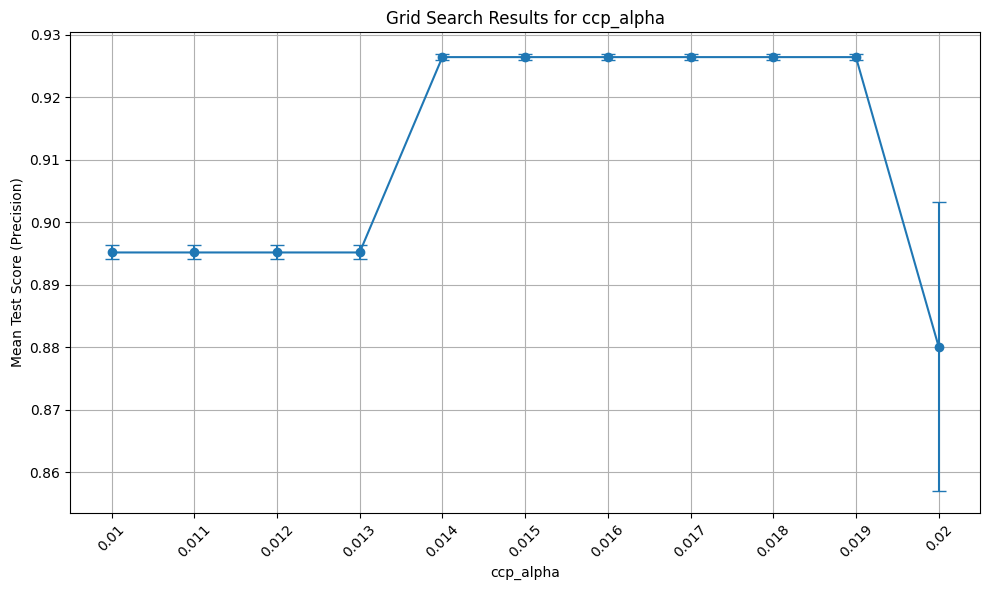

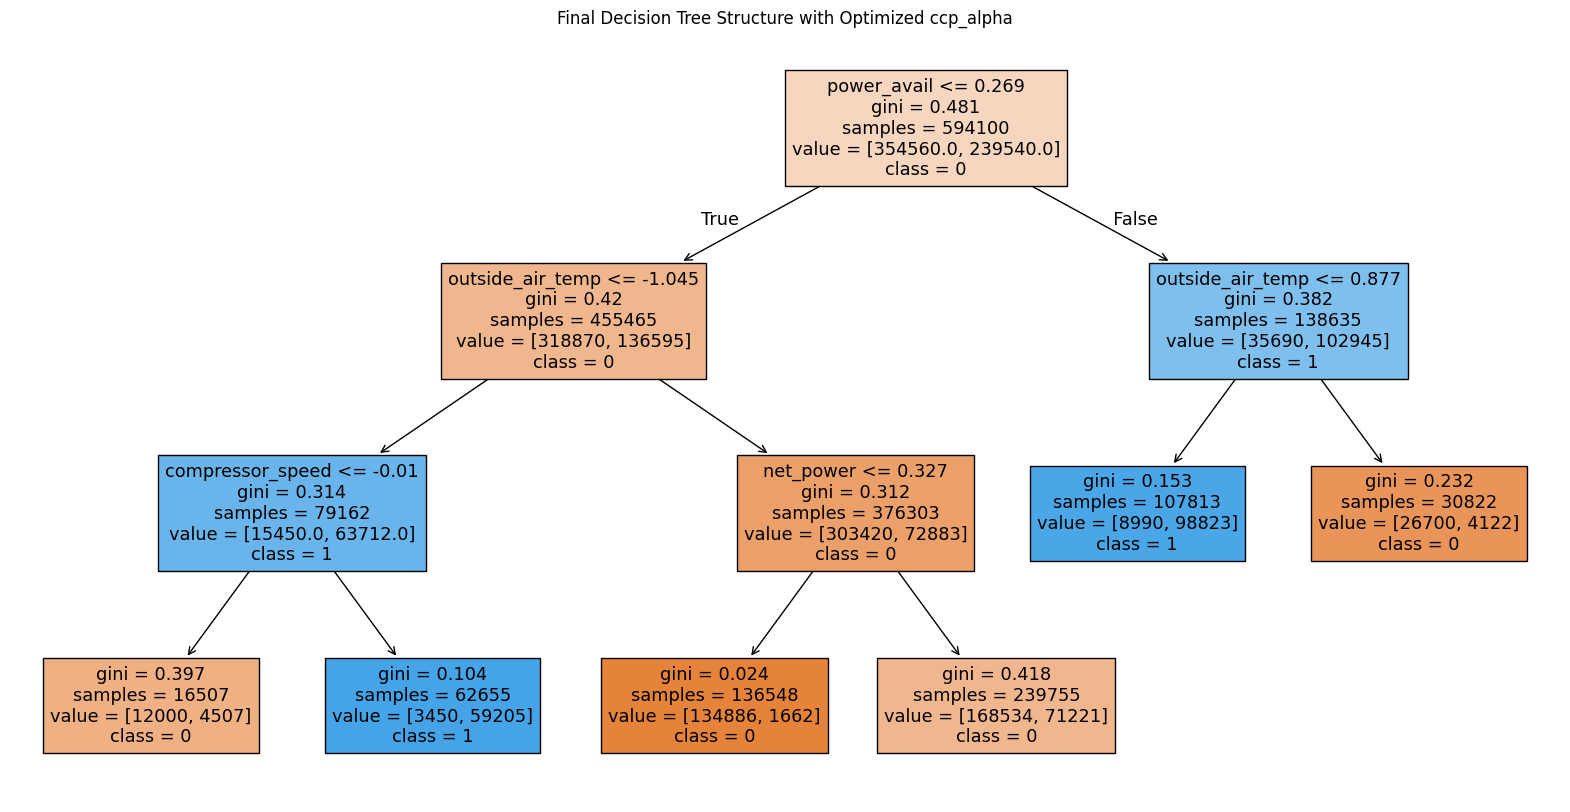

In [22]:
print("Predizioni:", y_pred)
print("Numero predizioni:", len(y_pred))
print("Feature names:", grid.best_estimator_.named_steps['rename_features'].column_names)
# Visualizza i parametri ottimizzati
print("Parametri ottimizzati:", grid.best_params_)
# Visualizza i risultati della griglia
print("Risultati della griglia:")
results_df = pd.DataFrame(grid.cv_results_)
print(results_df[['param_train_decision_tree__ccp_alpha', 'mean_test_score', 'std_test_score']])
# Visualizza i risultati della griglia
import matplotlib.pyplot as plt
# Visualizza i risultati della griglia
plt.figure(figsize=(10, 6))
plt.errorbar(
    results_df['param_train_decision_tree__ccp_alpha'].astype(str),
    results_df['mean_test_score'],
    yerr=results_df['std_test_score'],
    fmt='o-',
    capsize=5
)
plt.title('Grid Search Results for ccp_alpha')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Test Score (Precision)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
# Visualizza l'albero decisionale finale
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(grid.best_estimator_.named_steps['train_decision_tree'].model,
           feature_names=new_names_for_train_data, class_names=['0', '1'], filled=True)
plt.title("Final Decision Tree Structure with Optimized ccp_alpha")
plt.show()

# Esegui la valutazione

pipeline_final.named_steps['rename_features'].fit(X_train, y_train)
pipeline_final.named_steps['scale_data'].fit(pipeline_final.named_steps['rename_features'].transform(X_train))

evaluator = DecisionTreePerformanceEvaluator(
    model=grid.best_estimator_.named_steps['train_decision_tree'],
    X=pipeline_final.named_steps['scale_data'].transform(
        pipeline_final.named_steps['rename_features'].transform(X_train)
    ),
    y=y_train
)